<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

### Marcelo Chichiri

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### Conclusiones

Para este desafío usé un dataset para un bot de un servicio de venta y reclamos de un servicio de TV por cable (Cablin).

Se definieron 11 clases ('Subscripcion', 'agradecimientos', 'baja', 'consulta_pago', 'contacto', 'despedida', 'hablar_humano', 'nombre', 'reclamos_cobro', 'reclamos_servicios', 'saludos') con un vocabulario de 93 términos.

Para implementar este desafío se realizaron las siguientes taréas
* Se eliminaron mas signos de puntuación, como "~@#$%^&*()_+<>"
* Para ajustar un poco el modelo tuve que agregar algunos patterns que no había considerado inicialmente. Esto hizo que el modelo mejorase su respuesta. 
* Se probó sin stop words y con stop words. El resultado con stop words empeoró para algunos casos, ya que se eliminaban algunos terminos como 'no', 'como' y 'este' que hacían que algunos  documentos no tuviera sentido.Para evitar este problema se eliminó estos tres términos de la lista de stop words.

El resultado, dentro de este modelo básico, creo que resultó muy satisfactorio:

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [2]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
#!pip install -U spacy==3.1 --quiet
#!pip install -U spacy-stanza==1.0.0 --quiet

In [3]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [4]:
# Ignora los warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
import stanza
import spacy_stanza

from nltk.corpus import stopwords

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2022-10-30 15:07:38 INFO: Downloading default packages for language: es (Spanish)...
2022-10-30 15:07:40 INFO: File exists: C:\Users\Marcelo\stanza_resources\es\default.zip.
2022-10-30 15:07:50 INFO: Finished downloading models and saved to C:\Users\Marcelo\stanza_resources.
2022-10-30 15:07:51 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-10-30 15:07:51 INFO: Use device: cpu
2022-10-30 15:07:51 INFO: Loading: tokenize
2022-10-30 15:07:51 INFO: Loading: mwt
2022-10-30 15:07:51 INFO: Loading: pos
2022-10-30 15:07:51 INFO: Loading: lemma
2022-10-30 15:07:51 INFO: Loading: depparse
2022-10-30 15:07:52 INFO: Loading: ner
2022-10-30 15:07:55 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [6]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    #print(text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    #pattern = r'[^a-zA-z0-9.,<>@#$%^&*()~=+|¡!?¿/:;\´\"\'\s]' # [^ : ningún caracter de todos estos
    pattern = r'[^a-zA-z0-9.~@#$%^&*()_+<>,!?/:;\"\'\s]'
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    #pattern = r'[^a-zA-z.,<>@#$%^&*()~=+|¡!?¿/:;\´\"\'\s]' # igual al anterior pero sin cifras numéricas
    pattern = r'[^a-zA-z.~@#$%^&*()_+<>,!?/:;\"\'\s]'
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
       # Stop words
    #print(text)
    #text = [w for w in text if w not in nltk_stop_words]
    #print(text)
    ###### 
    return text

In [7]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos # <."

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los murcielagos  
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[murcielagos, 'murcielago']
[ , ' ']


### 3 - Diccionario de entrada

In [8]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag

#Servicio de venta y reclamo de TV por cable

dataset = {"intents": [
             {"tag": "saludos",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "Buen día",  "Buenas tardes",  "Buenas noches" ],
              "responses": ["Hola!, Soy Cablin ¿En te puedo ayudar?", "Hola, Soy Cablin ¿En te puedo ayudar?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?", "¿Como te llamas?", "¿Con quien estoy hablando?"
                          "¿Con quien hablo?"],
              "responses": ["Mi nombre es Cablin", "Yo soy Cablin", "Estas hablando con Cablin"]
             },
             {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Podes contactarnos al 011-000-1111", "Podés contactarnos por whatsapp al 011-000-2222"]
             },
             {"tag": "reclamos_servicios",
              "patterns": ["no funciona", "no enciende", "no se ve", "se apaga", 
                           "se ve con lluvia", "Se desconecta", "tengo problemas", "Tengo problemas con el cable",
                          "El sistema es malo", "El sistema es una porquería", "El servicio es deficiente", 
                           "El cable se corta", "se ve mal", "No se ven algunos canales", "Necesito un técnico",
                          "quiero soporte de un tecnico", "quiero hablar con un tecnico"],
              "responses": ["Por problemas técnicos comunicarte al 011-000-1111 (opcion 1) para programar una vista del técnico",
                            "Por problemas técnicos comunicate al 011-000-1111 (opcion 1) para solicitar la visita del técnico",
                           "Por problemas técnicos llama al 011-000-1111 (opcion 1) para agendar una visita del técnico"],
             },
             {"tag": "Subscripcion",
              "patterns": ["¿Cuanto cuesta?", "¿Que planes hay?", "¿Como me subscribo?", 
                           "¿Hay descuento?", "¿Hay promociones?", "Quiero subscribirme", "deseo subscribirme"],
              "responses": ["En www.cablin.com.ar podes encontar todos los planes y promociones. Para subscribirte podes enviar un mail con tus datos a <mail@subscripcion> o llamar al 011-000-1111 (opción 3)", 
                            "En nuestra web www.cablin.com.ar se detallan todos los planes y promociones. Para subscribirte envia un mail a <mail@subscripcion> o llamar al 011-000-1111 (opción 3)"],
             },
             {"tag": "baja",
              "patterns": ["Me quiero dar de baja", "Quiero darme de baja", "¿Como me borro?", 
                           "¿como me doy de baja?", "Quiero anular subscripción", 
                           "Quiero terminar subscripción"],
              "responses": ["Para darte de baja o cambiar tu subscripción podés llamar al 011-000-1111 (opción 2) para hablar con un representante", 
                            "Para darte de baja o cambiar tu subscripción podés comunicate al 011-000-1111 (opción 2) para hablar con un representante",
                           "Para darte de baja o cambiar tu subscripción llamá al 011-000-1111 (opción 2) y te atenderá un representante"],
             },
             {"tag": "consulta_pago",
              "patterns": ["¿cuales son los metodos de pagos?", "¿cuales son las formas de pago?", 
                           "¿Como pago la factura?", "¿puedo pagar con tarjeta?", "¿tienen debito automatico?", 
                           "¿tienen mercado de pago?"],
              "responses": ["En la pagina www.cablin.com.ar podrás encontrar el detalle de todas las formas de pago", 
                            "Visita nuestra web www.cablin.com.ar para ver todas las formas de pago"],
            },
             {"tag": "reclamos_cobro",
              "patterns": ["No me llegó la factura", "La factura está mal", "Me cobraron de mas",
                           "Me esta cobrando de mas", "No me hacen el descuento", "es muy caro"],
              "responses": ["Para consultar por facturación podés llamar al 011-000-1111 (opción 4) para hablar con un representante", 
                            "Para consultar por facturación podés podés comunicate al 011-000-1111 (opción 4) para hablar con un representante",
                           "Para consultar por facturación llamá al 011-000-1111 (opción 4) y te atenderá un representante"],
            },
             {"tag": "hablar_humano",
              "patterns": ["Quiero hablar con un humano", "humano", 
                           "pasame con un humano", "quiero hablar con una persona", "persona",
                          "quiero hablar con alguien humano"],
              "responses": ["Para hablar con un representante podés llamar al 011-000-1111", 
                            "Comunicate al 011-000-1111 para hablar con un representante"],
            },    
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias", "Agradecido"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme", 
                            "Gracias a vos por comunicarte con Cablin",
                            "A tu disposición para cualquier cosulta"],
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!", "adios", "hasta luego", ],
              "responses": ["Hasta luego!, gracias por tu visita", "Hablamos luego!, gracias por tu visita"]
             }
]}


### 4 - Preprocesamiento y armado del dataset

In [9]:
#Abre el diccionario de stop words y elimina algunas palabras que pueden ser útiles

nltk_stop_words = set(stopwords.words("spanish"))
for palabra in (['no', 'como', 'este']):
    nltk_stop_words.remove(palabra)

In [10]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Eliminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [11]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['adios', 'agradecido', 'alguien', 'alguno', 'anular', 'apagar', 'automatico', 'baja', 'borrar', 'buen', 'cable', 'canal', 'caro', 'chau', 'cobrar', 'como', 'con', 'contacto', 'cortar', 'costar', 'cual', 'cuanto', 'dar', 'de', 'debito', 'deficiente', 'desconectar', 'descuento', 'desear', 'dia', 'e', 'el', 'encender', 'estar', 'este', 'factura', 'forma', 'funcionar', 'gracias', 'haber', 'hablar', 'hacer', 'hasta', 'holar', 'humano', 'llama', 'llegar', 'lluvia', 'luego', 'mal', 'malo', 'mas', 'mercado', 'metodo', 'mucho', 'necesitar', 'no', 'noche', 'nombre', 'numero', 'pagar', 'pago', 'pasamar', 'persona', 'plan', 'poder', 'porqueria', 'problema', 'promoción', 'que', 'querer', 'quien', 'ser', 'servicio', 'sistema', 'soporte', 'subscribir', 'subscribirme', 'subscripcion', 'tal', 'tarde', 'tarjeta', 'tecnico', 'telefono', 'tener', 'terminar', 'tu', 'tú', 'uno', 'ver', 'whatsapp', 'yo', 'él']
classes: ['Subscripcion', 'agradecimientos', 'baja', 'consulta_pago', 'contacto', 'despedid

In [12]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 93


In [13]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 11


In [14]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)
    #print("text antes text_sin_stop_words", text)
    
    # Elimina las stop words del texto lematizado    
    #print("text antes de text_sin_stop_words", text)
    text = [w for w in text if w not in nltk_stop_words]
    #print("text despues de text_sin_stop_words", text)
    
    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    # print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

### 5 - Entrenamiento del modelo

In [15]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (93,) output: 11


In [16]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12032     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 11)                715       
                                                                 
Total params: 21,003
Trainable params: 21,003
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
hist = model.fit(x=train_X, y=train_y, epochs=250)

Epoch 1/250
3/3 [==============================] - 1s 6ms/step - loss: 2.4083 - accuracy: 0.0714
Epoch 2/250
3/3 [==============================] - 0s 7ms/step - loss: 2.3700 - accuracy: 0.0857
Epoch 3/250
3/3 [==============================] - 0s 6ms/step - loss: 2.3715 - accuracy: 0.1143
Epoch 4/250
3/3 [==============================] - 0s 5ms/step - loss: 2.3646 - accuracy: 0.1143
Epoch 5/250
3/3 [==============================] - 0s 5ms/step - loss: 2.3212 - accuracy: 0.2143
Epoch 6/250
3/3 [==============================] - 0s 6ms/step - loss: 2.3308 - accuracy: 0.1571
Epoch 7/250
3/3 [==============================] - 0s 6ms/step - loss: 2.2633 - accuracy: 0.2571
Epoch 8/250
3/3 [==============================] - 0s 6ms/step - loss: 2.2837 - accuracy: 0.2143
Epoch 9/250
3/3 [==============================] - 0s 8ms/step - loss: 2.2420 - accuracy: 0.2286
Epoch 10/250
3/3 [==============================] - 0s 6ms/step - loss: 2.2045 - accuracy: 0.3857
Epoch 11/250
3/3 [===========

3/3 [==============================] - 0s 8ms/step - loss: 0.1176 - accuracy: 1.0000
Epoch 168/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1325 - accuracy: 0.9857
Epoch 169/250
3/3 [==============================] - 0s 9ms/step - loss: 0.2345 - accuracy: 0.9286
Epoch 170/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1725 - accuracy: 0.9571
Epoch 171/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1748 - accuracy: 0.9714
Epoch 172/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1515 - accuracy: 0.9714
Epoch 173/250
3/3 [==============================] - 0s 9ms/step - loss: 0.2054 - accuracy: 0.9714
Epoch 174/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1513 - accuracy: 0.9714
Epoch 175/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1724 - accuracy: 0.9429
Epoch 176/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1462 - accuracy: 0.9857
Epoch 177/250
3/3 [=====

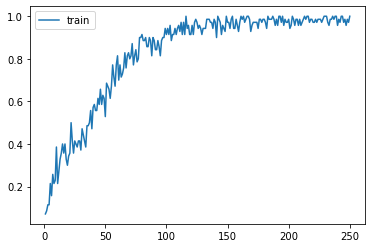

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [19]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [20]:
# convertir texto de entrada del usuario a tokens

def text_in_stop_words(text):
    text_sin_stop_words = [w for w in text if w not in nltk_stop_words]
    return text_sin_stop_words

def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    
    #print("lemma_tokens", lemma_tokens)
    lemma_tokens = text_in_stop_words(lemma_tokens)
    #print("lemma_tokens sin stop", lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print("bow", bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    #print(bow)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspondiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [21]:
Salida = False
while not Salida:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result, "\n")
        #print(message, words, classes, intents)
        if "despedida" in intents:
            Salida = True
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta. Por favor podés reformularla\n")
    

Hola
Q: Hola
BOT: Hola!, Soy Cablin ¿En te puedo ayudar? 

Buen día
Q: Buen día
BOT: Hola!, Soy Cablin ¿En te puedo ayudar? 

Como estas?
Q: Como estas?
BOT: Hola!, Soy Cablin ¿En te puedo ayudar? 

tengo problema con el servicio
Q: tengo problema con el servicio
BOT: Por problemas técnicos llama al 011-000-1111 (opcion 1) para agendar una visita del técnico 

el cable se corta
Q: el cable se corta
BOT: Por problemas técnicos comunicarte al 011-000-1111 (opcion 1) para programar una vista del técnico 

y me cobraron de mas
Q: y me cobraron de mas
BOT: Para consultar por facturación podés llamar al 011-000-1111 (opción 4) para hablar con un representante 

tampoco me llegó la factura
Q: tampoco me llegó la factura
BOT: Para consultar por facturación podés podés comunicate al 011-000-1111 (opción 4) para hablar con un representante 

quiero saber cuales son los planes
Q: quiero saber cuales son los planes
BOT: Mi nombre es Cablin 

como hago si me quiero dar de baja?
Q: como hago si me q

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words

### Alumno

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.